In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from scipy.stats import wasserstein_distance
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import bernoulli
from scipy.stats import nbinom

import ot
import gudhi
from gudhi.wasserstein import wasserstein_distance as wss

In [2]:
uniform_const = "Uniform"
soliton_const = "Soliton"
geometric_const = "Geometric"
binomial_const = "Binomial"
poisson_one_const = "Poisson(1)"
poisson_onehalf_const = "Poisson(1/2)"

poisson_with_hole_const = "Poisson with a hole in the support"
binomial_with_hole_const = "Binomial with a hole in the support"
uniform_with_hole_const = "Uniform with a hole in the support"

In [3]:
def first_nonzero(vec):
    dim = len(vec)
    
    for i in range(dim):
        if vec[i] > 0.0:
            return i

    return -1  # no empty cells found

def move_dirt(dirt, di, holes, hi):
    if dirt[di] <= holes[hi]:   # use all dirt
        flow = dirt[di]
        dirt[di] = 0.0            # all dirt got moved
        holes[hi] -= flow         # less to fill now
    elif dirt[di] > holes[hi]:  # use just part of dirt
        flow = holes[hi]          # fill remainder of hole
        dirt[di] -= flow          # less dirt left
        holes[hi] = 0.0           # hole is filled
        
    dist = np.abs(di - hi)
    
    return flow * dist  

def my_wasserstein(p, q):
    dirt = np.copy(p) 
    holes = np.copy(q)
    tot_work = 0.0

    while True:  # TODO: add sanity counter check
        from_idx = first_nonzero(dirt)
        to_idx = first_nonzero(holes)
        
        if from_idx == -1 or to_idx == -1:
            break
            
        work = move_dirt(dirt, from_idx, holes, to_idx)
        tot_work += work
        
    return tot_work

In [75]:
def display_wasserstein_distance_info(w_range, n_range, text="", text2="Poisson"):

    print(f"W_1({text},{text2}) is monotonically decreasing: {is_monot_decreasing(w_range)}")
    print(f"W_1({text},{text2}) is monotonically increasing: {is_monot_increasing(w_range)}")
    print()
    
    plt.figure(figsize=(10,5))
    
    plt.plot(n_range, w_range, c="black")
    plt.title(f"W_1({text},{text2})")
    plt.xlabel("n")
    plt.ylabel("W_1")
    plt.show()
    
def plot_pmf(x, y, title=""):
    plt.plot(x, y, 'ro')
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    plt.show()
    
def get_relative_entropy(p1, p2=[]):
    if np.size(p2) == 0:
        return scipy.stats.entropy(p1)
    
    return scipy.stats.entropy(p1, p2)

def is_monot_increasing(arr):
    return all(float(fst) <= float(snd) for fst, snd in zip(arr, arr[1:]))

def is_monot_decreasing(arr):
    return all(float(fst) >= float(snd) for fst, snd in zip(arr, arr[1:]))

In [5]:
def poi_pmf(k, k_star=5, lmb=1):
    if k == k_star:
        return 0
    elif k == k_star - 1:
        return poisson.pmf(k,lmb)+poisson.pmf(k_star,lmb)
    else:
        return poisson.pmf(k,lmb)
    
def get_poisson_pmf_array(n_max, poisson_param):
    poisson_arr = []
    
    for k in range(0,n_max):
        poisson_pmf_k = poisson.pmf(k,poisson_param)#poisson_param**k/(np.exp(poisson_param)*np.math.factorial(k))
        poisson_arr.append(poisson_pmf_k)
        
    return poisson_arr

def get_binom_pmf_array(n, p=0):
    if p == 0:
        p = 1/n
        
    binom_arr = []
    
    for k in range(0,n):
        binom_pmf_k = binom.pmf(k, n, p)
        binom_arr.append(binom_pmf_k)
        
    return binom_arr

def pmf_of_sum(n, k):
    if n == 1:
        return poi_pmf(k)
    
    return sum(pmf_of_sum(n-1,i)*poi_pmf(k-i) for i in range(0, k))

def get_thinning_pmf_array(n, rv=""):
    thinning_arr = []
    
    for k in range(0,n):
        thinning_pmf_k = pmf_of_sum(n, k)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr


In [6]:
def pmf_of_sum_poi(n, k):
    if n == 1:
        return poi_pmf(k)
    
    return sum(pmf_of_sum_poi(n-1,i)*poi_pmf(k-i,k_star) for i in range(1, k))

def thinning_pmf(n, k, l):
    #print(n)
    
    #return sum(pmf_of_sum_poi(n,j) * binom_func(j,k,1/n) for j in range(k, k+10))
    #return sum(poisson.pmf(j,n) * binom.pmf(k,j,1/n) for j in range(k, k+300)) # does not work
    return sum(binom_func(n,j,0.5) * binom_func(j,k,1/n) for j in range(k, n+1)) # works
    #return sum(np.exp(-n)*n**j/np.math.factorial(j) * binom_func(j,k,1/n) for j in range(k, k+100))
    
    #return sum(pmf_of_sum_bin(n,j,l) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    
def get_poisson_pmf_array(K, poisson_param):
    poisson_arr = []
    
    for k in range(0,K+1):
        poisson_pmf_k = poisson.pmf(k,poisson_param)#poisson_param**k/(np.exp(poisson_param)*np.math.factorial(k))
        poisson_arr.append(poisson_pmf_k)
        
    return poisson_arr

In [63]:
def uniform_pmf(n,k,k_star=1):
    if k > n or k < 0:
        return 0
    
    if k < k_star:
        return 1/(k_star)/2
    elif k == k_star:
        return 0
    else:
        return 1/(n-k_star)/2
    
    if k == k_star:
        return 0
    elif k == k_star-1:
        return 2/(n+1)
    else:
        return 1/(n+1)
    
    return 1/(n+1)
    
def benford_pmf(d):
    return np.log10(1+1/d)
    
def soliton_pmf(n, k):
    if k == 0:
        return 0
    
    if k == 1:
        return 1/n
    else:
        return 1/(k*(k-1))
    
def geom_pmf(k, k_star,p):
    #if k < 0 or k > l:
    #    return 0
    #
    #return (1-p)**k * p

    if k == k_star:
        return 0
    elif k == k_star+1:
        return (1-p)**k * p + (1-p)**k_star * p 
    else:
        return (1-p)**k * p

def custom_dist_pmf(k,dist):
    if k >= np.size(dist) or k < 0:
        return 0
    #print(k)
    return dist[0,k]

def binom_func(n,m,p):
    return scipy.special.binom(n,m) * (p**m) * (1-p)**(n-m)
    
def q_binom_coef(n,m,q):
    s = 1
    for i in range(0,m):
        s *= (1-q**(n-i))/(1-q**(i+1))
        
    return s

def get_binomial_pmf_array(K, p):
    bin_arr = []
    
    for k in range(0,K+1):
        bin_pmf_k = binom_func(K,k,p)#binom.pmf(k,n,p)
        bin_arr.append(bin_pmf_k)
        
    return bin_arr

def bin_pmf(n, m, p, k_star=4):
    if m == k_star: #or m == n-k_star:
        return 0
    elif m == k_star + 1:
        return binom.pmf(m,n,p) + binom.pmf(k_star,n,p)#binom_func(n,m,p) + binom_func(n,k_star,p) #binom.pmf(k,j,p) + binom.pmf(k_star,j,p)
    #elif m == n - k_star - 1:
    #    return binom_func(n,m,p) + binom_func(n,n-k_star,p)
    else:
        return binom.pmf(m,n,p)#binom_func(n,m,p)#binom.pmf(k,j,p)
    #return binom_func(n,m,p) #binom.pmf(k,j,p)

def pmf_of_sum_bin(n, l, k, k_star, dist, p=0.5):
    #print(n, l, k)
    #return binom_func(l*n,k,p)

    if n == 1:
        #return custom_dist_pmf(k,dist)
        #return geom_pmf(k,k_star)
        return bin_pmf(l,k,p,k_star)
        #return soliton_pmf(l, k)
        #return uniform_pmf(l,k)
    
    #return sum(pmf_of_sum_bin(n-1,l*n+1,i,p)*soliton_pmf(l*n+1,k-i) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,p)*uniform_pmf(k) for i in range(0, k+1))
    
    #return sum(pmf_of_sum_bin(n-1,l,i,k_star,dist,p)*custom_dist_pmf(k-i,dist) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,k_star,p)*geom_pmf(k-i,k_star) for i in range(0, k+1))
    return sum(pmf_of_sum_bin(n-1,l,i,k_star,p)*bin_pmf(l,k-i,p,k_star) for i in range(0, k+1))
    #return sum(pmf_of_sum_bin(n-1,l,i,p)*uniform_pmf(l,k-i) for i in range(0, k+1)) #uniform

def thinning_pmf(n, k, l,k_star,dist,p):
    #binom_func(l*n+1,j,0.5)
    #return pmf_of_sum_bin(n,l,k,k_star)
    #print(n,k,p,pmf_of_sum_bin(n,l,1,k_star,dist,p))
    return sum(pmf_of_sum_bin(n,l,j,k_star,dist,p) * binom.pmf(k,j,1/n) for j in range(k, l*n+1))#binom_func(j,k,1/n) for j in range(k, l*n+2))

    #return sum(pmf_of_sum_bin(n,l,j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    #return sum(nbinom.pmf(j,n,0.5) * binom_func(j,k,1/n) for j in range(k, l*n+1)) #sum of geom RV
    #return sum(benford_pmf(n*j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    #return sum(benford_pmf(n*j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    

def thinning1_pmf(n, k, l,k_star,dist,p):
    #binom_func(l*n+1,j,0.5)
    #return pmf_of_sum_bin(n,l,k,k_star)
    return sum(pmf_of_sum_geom(n,l,j,k_star,dist,p) * binom.pmf(k,j,1/n) for j in range(k, l*n+1))#binom_func(j,k,1/n) for j in range(k, l*n+2))

    #return sum(pmf_of_sum_bin(n,l,j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    #return sum(nbinom.pmf(j,n,0.5) * binom_func(j,k,1/n) for j in range(k, l*n+1)) #sum of geom RV
    #return sum(benford_pmf(n*j) * binom_func(j,k,1/n) for j in range(k, l*n+1))
    #return sum(benford_pmf(n*j) * binom_func(j,k,1/n) for j in range(k, l*n+1))


def pmf_of_sum_geom(n, l, k, k_star, dist, p=0.5):
    #print(n, l, k)
    #return binom_func(l*n,k,p)

    if n == 1:
        #return uniform_pmf(l,k,k_star)
        return custom_dist_pmf(k,dist)
        #return geom_pmf(k,k_star,p)
    
        #return bin_pmf(l,k,p,k_star)
        #return soliton_pmf(l, k)
    
    #return sum(pmf_of_sum_bin(n-1,l*n+1,i,p)*soliton_pmf(l*n+1,k-i) for i in range(0, k+1))
    
    #return sum(pmf_of_sum_geom(n-1,l,i,k_star,dist,p)*uniform_pmf(l,k-i,k_star) for i in range(0, k+1))
    return sum(pmf_of_sum_geom(n-1,l,i,k_star,dist,p)*custom_dist_pmf(k-i,dist) for i in range(0, k+1))
    #return sum(pmf_of_sum_geom(n-1,l,i,k_star,dist,p)*geom_pmf(k-i,k_star,p) for i in range(0, k+1))

    #return sum(pmf_of_sum_bin(n-1,l,i,k_star,p)*bin_pmf(l,k-i,p,k_star) for i in range(0, k+1))
    #return sum(pmf_of_sum_geom(n-1,l,i,k_star,dist,p)*uniform_pmf(l,k-i) for i in range(0, k+1)) #uniform

    
def get_thinning_pmf_array(K,n,l,k_star=0,dist=[],p=0.5):
    thinning_arr = []
    
    for k in range(0,n*K+1):
        thinning_pmf_k = thinning_pmf(n,k,l,k_star,dist,p)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr
   
def get_thinning1_pmf_array(K,n,l,k_star=0,dist=[],p=0.5):
    thinning_arr = []
    
    for k in range(0,n*K+1):
        thinning_pmf_k = thinning1_pmf(n,k,l,k_star,dist,p)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr


In [69]:
K = 5

dist1 = np.random.dirichlet(np.ones(K+1),size=1)
dist2 = np.random.dirichlet(np.ones(K+1),size=1)

exp1 = 0
exp2 = 0

for x in range(0,np.size(dist1)):
    exp1 += x*dist1[0,x]
    
for x in range(0,np.size(dist2)):
    exp2 += x*dist2[0,x]
    
print(f"E[dist1]={exp1}")
print(f"E[dist2]={exp2}")

E[dist1]=3.257089080123289
E[dist2]=3.4911015677564725


[[0.09403831 0.08390511 0.471786   0.13371607 0.2165545 ]]
[[0.18209738 0.28435753 0.11847032 0.06918882 0.34588596]]
E[dist1]=2.294843350329939
E[dist2]=2.1124084377431873
p1 [0.1615592  0.29216927 0.02648327 0.39563212 0.12415614]
[0.09403830825484012, 0.08390511435409455, 0.4717859996427194, 0.1337160743029783, 0.21655450344536767]
n=1, pmf1 sum=1.0
n=1, pmf2 sum=1.0


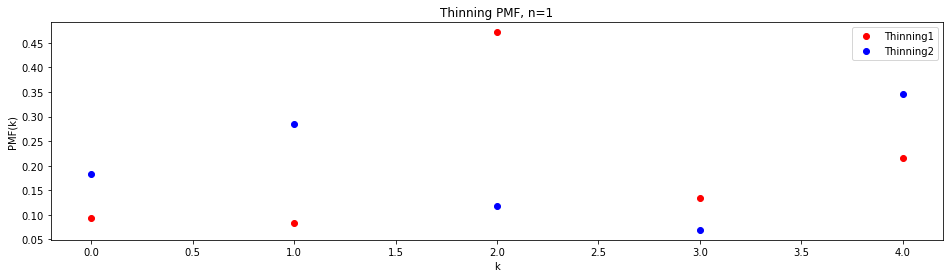

[0.08076198445624991, 0.2171910970920862, 0.28771583595810035, 0.23079833589457865, 0.1239921029392951, 0.04567101961614573, 0.011768491430436196, 0.0019179456874732002, 0.0001831869256346475]
n=2, pmf1 sum=1.0
n=2, pmf2 sum=1.0000000000000002


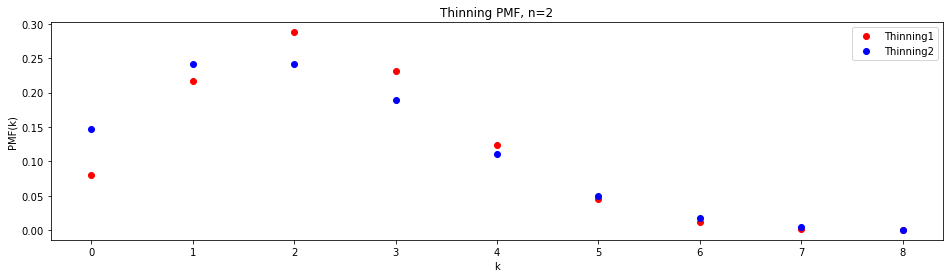

[0.08638224387656768, 0.22431230879405242, 0.27992612699260205, 0.21993656111297755, 0.12094224771668488, 0.04907280378572531, 0.015110253595692161, 0.0035725315560728344, 0.0006473400943607399, 8.829659705110124e-05, 8.701948354948892e-06, 5.648204784341272e-07, 1.910938025469357e-08]
n=3, pmf1 sum=1.0000000000000002
n=3, pmf2 sum=1.0000000000000004


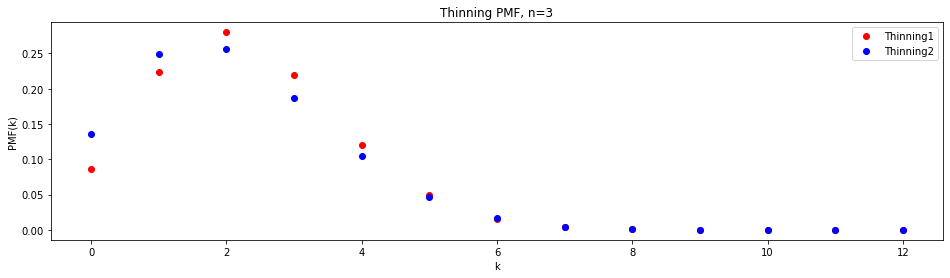

[0.08970779275371724, 0.22664170151075202, 0.2763369461119036, 0.21518636605005192, 0.1196453593027438, 0.05036038304969935, 0.01661025151624252, 0.004384357917612978, 0.0009375172720856895, 0.00016327678912485166, 2.314030541630803e-05, 2.648667385148939e-06, 2.4093324319035116e-07, 1.691908094028258e-08, 8.707913385703476e-10, 2.9636985651632205e-11, 5.120460468059367e-13]
n=4, pmf1 sum=0.9999999999999999
n=4, pmf2 sum=1.0000000000000002


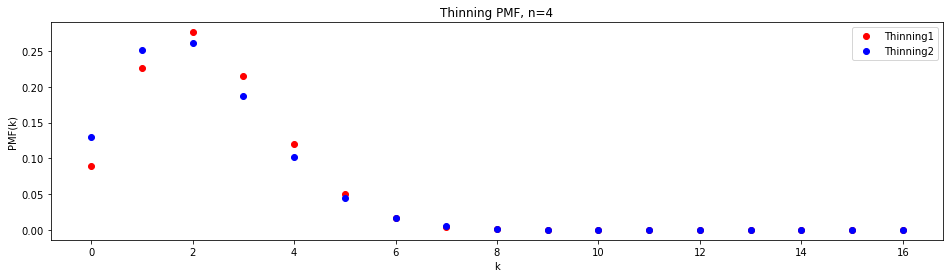

[0.09181204511132951, 0.22780260571611913, 0.2741730297668383, 0.2125339687773241, 0.11892852334202723, 0.05105460898581309, 0.01744903035509594, 0.004863860402116174, 0.0011237769122049682, 0.00021751775796605025, 3.5500386922631395e-05, 4.899712541950468e-06, 5.71667349608397e-07, 5.616636571561095e-08, 4.610218848000724e-09, 3.119734492457321e-10, 1.7043243554940756e-11, 7.269295092290441e-13, 2.287604111417917e-14, 4.765974781140063e-16, 4.993855961718211e-18]
n=5, pmf1 sum=1.0000000000000002
n=5, pmf2 sum=1.0000000000000007


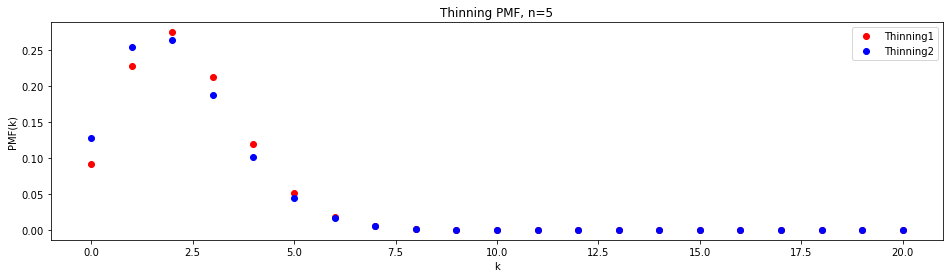

[0.09325152934709988, 0.22849849749953524, 0.27272072980555184, 0.21083545171245235, 0.11847534769929328, 0.05149159413273661, 0.017985263089934547, 0.005179324723286078, 0.0012518364655034683, 0.00025718857549471156, 4.532106136758839e-05, 6.892574027861248e-06, 9.081858479421098e-07, 1.0386386152781598e-07, 1.030812761445004e-08, 8.858595158096322e-10, 6.562567071755994e-11, 4.160695124937695e-12, 2.2333151037458166e-13, 9.990106901537394e-15, 3.6383441575749395e-16, 1.0409360394802195e-17, 2.2054766831464724e-19, 3.0957173777452763e-21, 2.1765733582882434e-23]
n=6, pmf1 sum=0.9999999999999999
n=6, pmf2 sum=1.0000000000000007


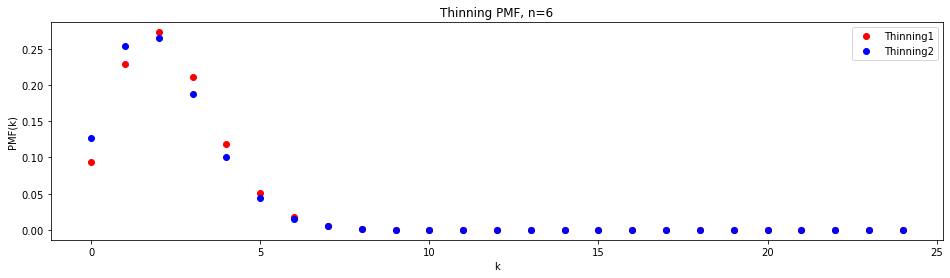

H(Binomial with a hole in the support|Poisson(3.257089080123289)) is monotonically decreasing: True (should always be true)
[0.42007858418728516, 0.03442349685645818, 0.018275565310529727, 0.01337954434934644, 0.011244822720888847, 0.01011684507265059]

H(Binomial with a hole in the support) is monotonically increasing: False (should be true in ULC case)
H(Binomial with a hole in the support) is monotonically decreasing: False (should be true in ULConvex case)
[1.4724510671155857, 1.7699454920327464, 1.7586436492431543, 1.7524855637826835, 1.7488722327137518, 1.7465302691307945]

H(Binomial with a hole in the support)_6=1.7465302691307945, H(Poisson(3.257089080123289))=1.7571257838379644
H(Binomial with a hole in the support|Poisson(3.257089080123289))=0.01011684507265059

SciPy [0.5707062120614289, 0.22532179060073126, 0.19310998551511982, 0.18569928524433726, 0.1834053406109527, 0.18270162397805556]

W_1(Thinning1,Thinning2) is monotonically decreasing: True
W_1(Thinning1,Thinning2) 

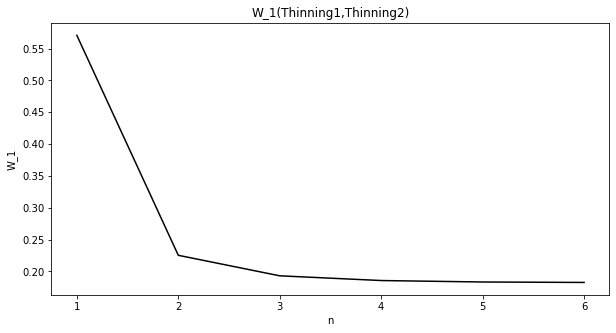

In [77]:
K = 4
l = K
K_range = range(0,K+1)

#dist3 = np.random.dirichlet(np.ones(K+1),size=1)
#dist4 = np.random.dirichlet(np.ones(K+1),size=1)
#
#exp3 = 0
#exp4 = 0
#
#for x in range(0,np.size(dist3)):
#    exp3 += x*dist3[0,x]
#    
#for x in range(0,np.size(dist4)):
#    exp4 += x*dist4[0,x]
    
print(dist3)
print(dist4)
print(f"E[dist1]={exp3}")
print(f"E[dist2]={exp4}")


p = 0.5
#lmb = 1 #for geom RV
lmb = 0

for x in range(0,np.size(dist1)):
    lmb += x*dist1[0,x]
    
p3 = get_binomial_pmf_array(K, p)
p1 = np.random.dirichlet(np.ones(K+1),size=1)[0] #get_poisson_pmf_array(K, lmb)
print("p1", (p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

#print(dist)

n_max = 6
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []
w_range1 = []

entropy = []
rel_entropy = []

k_star = 3

for n in n_range:
    K_range = range(0,n*K+1)
    #p1 = get_thinning_1_array(n, K, p)
    p1 = get_thinning1_pmf_array(K, n, l, 2, dist3, 0.5)
    p2 = get_thinning1_pmf_array(K, n, l, 2, dist4, 0.4)#get_thinning_pmf_array(K, n, l, 3, dist2, 0.8)
    p3 = get_poisson_pmf_array(K*n, exp3)
    #print(poisson.pmf(0,n))
    print(p1)
    print(f"n={n}, pmf1 sum={sum(p1)}")
    print(f"n={n}, pmf2 sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.title(f"Thinning PMF, n={n}")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    plt.plot(K_range, p1, 'ro', label=f'Thinning1')
    plt.plot(K_range, p2, 'bo', label=f'Thinning2')
    #plt.plot(K_range, p3, 'ko', label=f'Poisson({exp3})')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    dists = [i for i in range(len(p1))]
    w = wasserstein_distance(dists, dists, p1, p2)
    w_range.append(w)
    
    #M = ot.dist(np.array(p1).reshape((K*n+1, 1)), np.array(p2).reshape((K*n+1, 1)))
    #M = ot.dist(np.array(range(0,K*n+1)).reshape((K*n+1, 1)), np.array(range(0,K*n+1)).reshape((K*n+1, 1)))
    #M = M/ M.max()
    #W = ot.emd2(p1, p2, M)
    #dgm1 = np.array([p1])
    #dgm2 = np.array([p2])
    #W = wss(dgm1,dgm2)
    W = 0#my_wasserstein(p1,p2)
    w_range1.append(W)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print("SciPy",w_range)
#print("SciPy",w_range1)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning1", "Thinning2")

#print("Monotonic for 2^n:", w_range[0]>=w_range[1]>=w_range[3])

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

In [ ]:
K = 4
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 0

for x in range(0,np.size(dist)):
    lmb += x*dist[0,x]
    
p3 = get_binomial_pmf_array(K, p)
p1 = np.random.dirichlet(np.ones(K+1),size=1)[0] #get_poisson_pmf_array(K, lmb)
print("p1", sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

#print(dist)

n_max = 8
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 2

for n in n_range:
    #p1 = get_thinning_1_array(n, K, p)
    p1 = get_thinning_pmf_array(K, n, l, k_star, dist1)
    p2 = get_thinning1_pmf_array(K, n, l, k_star, dist2)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)", "Thinning'(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

2.2278662800344593
p1 0.9244556242601568
n=1, pmf sum=1.0


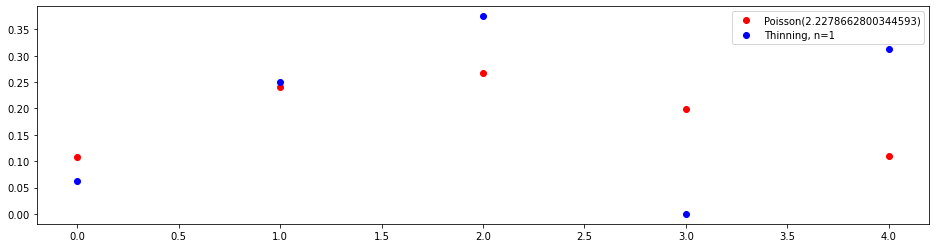

n=2, pmf sum=1.0


ValueError: x and y must have same first dimension, but have shapes (5,) and (9,)

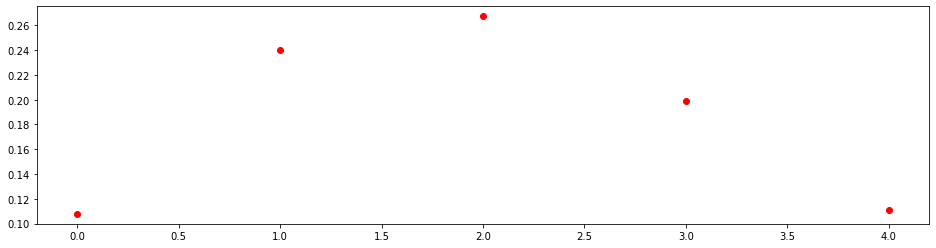

In [78]:
dist = np.random.dirichlet(np.ones(K+1),size=1)

K = 4
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 0

for x in range(0,np.size(dist)):
    lmb += x*dist[0,x]
    
print(lmb)

p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print("p1", sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

#print(dist)

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 3

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star, dist)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

2.737739794318436
p1 0.9780341000857815
[[0.17504764 0.17053155 0.01344013 0.22376222 0.28507222 0.06412496
  0.06802126]]
n=1, pmf sum=0.9999999999999999


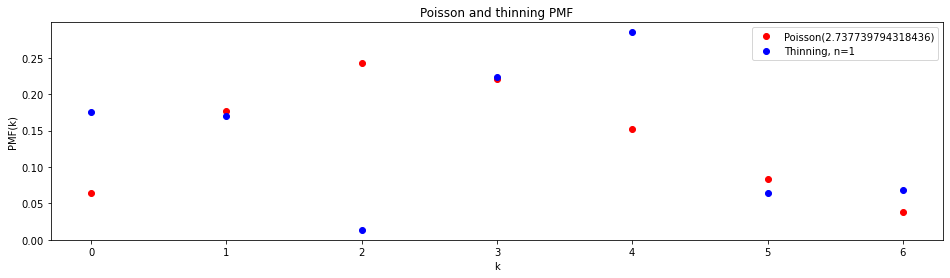

n=2, pmf sum=0.9999999999999999


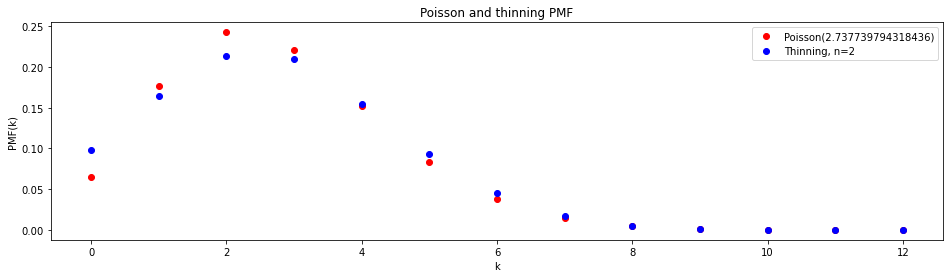

n=3, pmf sum=0.9999999999999999


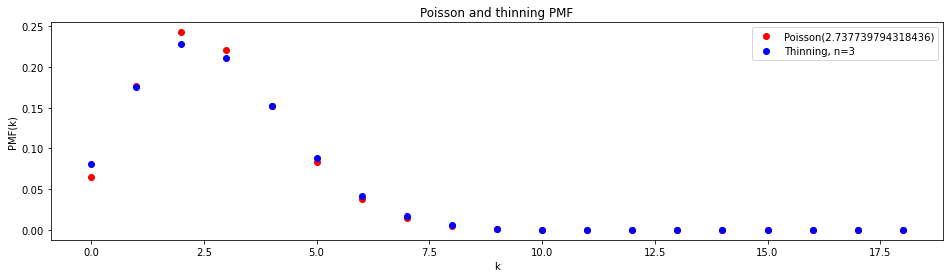

n=4, pmf sum=0.9999999999999993


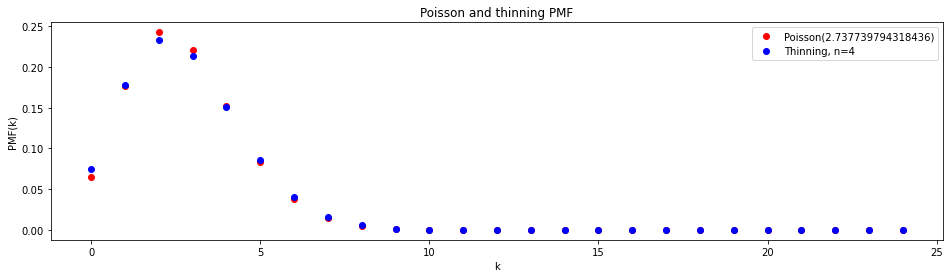

n=5, pmf sum=0.9999999999999993


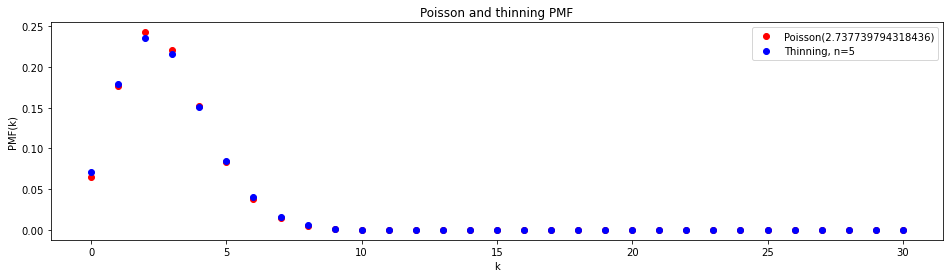

n=6, pmf sum=0.9999999999999993


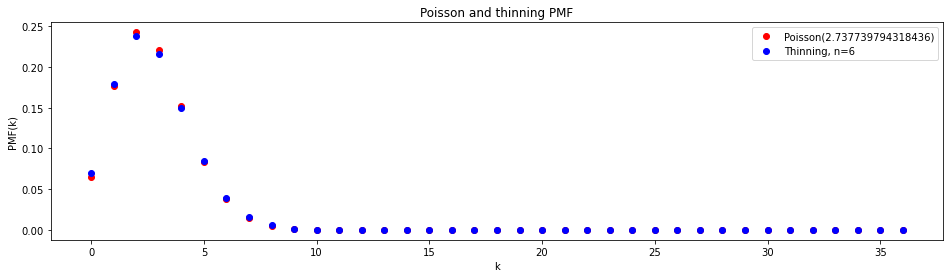

H(Binomial with a hole in the support|Poisson(2.737739794318436)) is monotonically decreasing: True (should always be true)
[0.3126272981882713, 0.011519910536632968, 0.002933201778299813, 0.0012602143562352808, 0.0006957937556617129, 0.00044226028003450414]

H(Binomial with a hole in the support) is monotonically increasing: False (should be true in ULC case)
H(Binomial with a hole in the support) is monotonically decreasing: False (should be true in ULConvex case)
[1.7163801882578102, 1.9326097223565462, 1.9155659968515961, 1.9062697580752963, 1.9008057954624569, 1.8972606704867374]

H(Binomial with a hole in the support)_6=1.8972606704867374, H(Poisson(2.737739794318436))=1.8811630779862432
H(Binomial with a hole in the support|Poisson(2.737739794318436))=0.00044226028003450414

[0.520205053098656, 0.11213561460796219, 0.06038301071933547, 0.04294010900715352, 0.03364822787717536, 0.027628031445405335]

W_1(Thinning,Poisson(2.737739794318436)) is monotonically decreasing: True
W_1(T

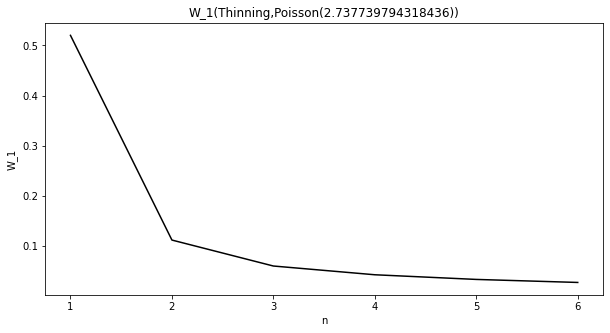

In [83]:
K = 6
l = K
K_range = range(0,K+1)

dist = np.random.dirichlet(np.ones(K+1),size=1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 0

for x in range(0,np.size(dist)):
    lmb += x*dist[0,x]
    
print(lmb)

p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print("p1", sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

print(dist)

n_max = 6
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 1

for n in n_range:
    K_range = range(0,n*K+1)
    p=0.5
    #lmb=p*(n)
    p2 = get_thinning1_pmf_array(K, n, l, k_star, dist, p)
    p1 = get_poisson_pmf_array(K*n, lmb)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.title("Poisson and thinning PMF")
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])
    
    dists = [i for i in range(len(p1))]
    w = wasserstein_distance(dists, dists, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning", f"Poisson({lmb})")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Geometric distribution with a hole in the support -> Poisson distribution

In [ ]:
from decimal import Decimal

K = 9
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = (1-p)/p
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 3

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Binomial distribution with a hole in the support -> Poisson distribution

In [ ]:
from decimal import Decimal

K = 9
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = l*p
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 3

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Uniform distribution with a hole in the support -> Poisson distribution

In [ ]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = K/2
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 1

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = uniform_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Uniform distribution with a hole in the support vs Binomial distribution

In [ ]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = K/2
p1 = get_binomial_pmf_array(K, p)
p3 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 1

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = uniform_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Binomial distribution with a hole in the support vs Binomial distribution

In [ ]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = 5
p1 = get_binomial_pmf_array(K, p)
p3 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 4

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l, k_star)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Binomial({l+1},{p})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Binomial({l+1},{p})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)}")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Binomial({l+1},{p}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Binomial({l+1},{p}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)", f'Binomial({l+1},{p})')

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Geometric distribution -> Poisson distribution

In [ ]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
lmb = 1
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 100
n_step = 10
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
thinning_rv = geometric_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Binomial distribution -> Poisson distribution

In [ ]:
from decimal import Decimal

K = 10
l = K
K_range = range(0,K+1)

p = 0.5
lmb = 5
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 100
n_step = 10
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)
    
print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

## Uniform distribution -> Poisson distribution

In [ ]:
from decimal import Decimal

K = 9
l = K
K_range = range(0,K+1)

p = 0.5
#lmb = 1 #for geom RV
lmb = K/2
p3 = get_binomial_pmf_array(K, p)
p1 = get_poisson_pmf_array(K, lmb)
print(sum(p1))
#plot_pmf(K_range,p1,f"Binomial({K},{p})")
#plot_pmf(K_range,p1,f"Poisson({lmb})")

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    p2 = get_thinning_pmf_array(K, n, l)
    #print(poisson.pmf(0,n))
    print(f"n={n}, pmf sum={sum(p2)}")
    #plot_pmf(K_range,p2)
    plt.figure(figsize=(16,4))
    #plt.plot(K_range, p3, 'ko', label='Binomial(K,p)')
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    plt.legend()
    plt.show()
    #plt.plot(K_range, list(zip(p1, p2)), 'rbo',  label=['Poisson(lmb)', f'Thinning, n={n}'])

    w = wasserstein_distance(p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

#print(p2)
#plot_pmf(K_range,p2)

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true only in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()
display_wasserstein_distance_info(w_range, n_range, f"Thinning(...)")

#plt.plot(K_range, list(zip(p1, p2)), label=['Poisson(lmb)', f'Thinning, n={n}'])
#plt.legend()
#plt.show()

In [ ]:
def thinning_pmf(n, k, rv):
    
    #c = (np.exp(-1/n)*(1/n)**k)/np.math.factorial(k) #with n=1, Y\sim Poisson(1). Does not make sense since we are interested in increasing n
    
    if rv == poisson_one_const:
        c = poisson.pmf(k,1)#1/(np.exp(1)*np.math.factorial(k)) #with Y_i\sim Poisson(1), i=1,...,n
        #print(c)
        #print(poisson.pmf(k,1))
        #print()
    
    if rv == poisson_onehalf_const:
        c = 0.5**k/(np.exp(0.5)*np.math.factorial(k)) #with Y_i\sim Poisson(0.5), i=1,...,n
    
    if rv == geometric_const:
        l = 0.5/n
        c = 1/(1+l)*(l/(1+l))**k #geometric
    
    if rv == binomial_const:
        c = binom.pmf(k, n, 1/n) #binomial
    
    if rv == soliton_const:
        # soliton distribution (https://en.wikipedia.org/wiki/Soliton_distribution)
        if k == 1:
            c = 1/n
        else:
            c = 1/(k*(k-1)) #k should be >0
        
    if rv == uniform_const:
        c = 1/n #uniform
    
    
    k_star = 5
    
    if rv == uniform_with_hole_const:
        if k < k_star:
            c = 1/(k_star)/2
        elif k == k_star:
            c = 0
        else:
            c = 1/(n-k_star-1)/2
                    
    if rv == poisson_with_hole_const:
        lmb = 1
        
        if k == k_star:
            c = 0
        elif k == k_star - 1:
            c = poisson.pmf(k,lmb) + poisson.pmf(k_star,lmb)#np.exp(-lmb)*lmb**k/np.math.factorial(k)+np.exp(-lmb)*lmb**k_star/np.math.factorial(k_star)
        else:
            c = poisson.pmf(k,lmb)#np.exp(-lmb)*lmb**k/np.math.factorial(k)
    
    if rv == binomial_with_hole_const:
        p = 1/n
        
        if k == k_star:
            c = 0
        elif k == k_star - 1:
            c = binom.pmf(k, n, p) + binom.pmf(k_star, n, p)
        else:
            c = binom.pmf(k, n, p)
        
    return c
    #print(c)
  

In [ ]:
# Init
n_min = 1
n_max = 10
n_step = 1

poisson_param = 1

n_range = range(n_min,n_max+n_step,n_step)
k_range = range(n_min,n_max)

poisson_arr = get_poisson_pmf_array(n_max, poisson_param)
    
#print(f"poisson pmf sum={sum(poisson_arr)}")

# Law of small numbers
w_range = []
for n in n_range:
    binom_arr = get_binom_pmf_array(n, 1/n)
    
    #print(f"binom pmf sum={sum(binom_arr)}, n={n}")
    
    w = wasserstein_distance(poisson_arr[:n], binom_arr)
    w_range.append(w)
    #print(w)
    
#print(np.size(poisson_arr), np.size(binom_arr))
    
display_wasserstein_distance_info(w_range, n_range, "Binomial")

# Law of thin numbers
w_range = []

entropy = []
rel_entropy = []

thinning_rv = binomial_const

for n in n_range:
    thinning_arr = get_thinning_pmf_array(n, thinning_rv)
    
    print(f"thinning pmf sum={sum(thinning_arr)}, n={n}")

    w = wasserstein_distance(poisson_arr[:n], thinning_arr)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(thinning_arr, poisson_arr[:n]))
    entropy.append(get_relative_entropy(thinning_arr))


print(f"H({thinning_rv}|Poisson) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true only in ULC case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson(1))={scipy.stats.entropy(poisson_arr)}")
print(f"H({thinning_rv}|Poisson)={rel_entropy[-1]}")

plot_pmf(range(0,n), thinning_arr, title=thinning_rv)
#print(np.size(poisson_arr), np.size(thinning_arr))

    
display_wasserstein_distance_info(w_range, n_range, f"Thinning({thinning_rv})")


In [ ]:
from ot.datasets import make_1D_gauss as gauss

n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a = gauss(n, m=20, s=5)  # m= mean, s= std
b = gauss(n, m=60, s=10)

# loss matrix
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()

In [ ]:
print(x.reshape((n, 1)))